# Acknowledgments:
* https://spinningup.openai.com/
* https://github.com/girafe-ai/reinforcement-learning

This code allows you to run spinningup with mujoco in colab notebook. Also it creates a video.

Author: Andrei Pitkevich (github.com/andreipit, https://www.linkedin.com/in/andrew-pt)

# Main parameters

In [1]:
'''
If there is an error after 1st run - restart and run all again.
CREATE output folder manually at your google drive! Notebook won't create it by itself!
Manual folder cleaning maybe useful (not sure)
'''
output_path = '/content/drive/MyDrive/Colab Notebooks/mipt_3_sem/RL/Spinningup_recreate/output'

models = ['td3', 'ddpg']
MODEL = models[0]

environments = ['Humanoid-v2','Ant-v2', 'HalfCheetah-v2']
ENVIRONMENT = environments[2]

EPOCHS = 1 # 50

# solutions: 
# HalfCheetah-v2 => 100 epochs of ddpg
# Ant-v2=> 100 epochs of td3
# Humanoid-v2 => 1000 epochs of td3 (not stable)


# mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utils from openai

## install requrements (uncomment at 1st run only)

In [3]:
!pip install 'cloudpickle==1.2.1'
# !pip install 'gym[atari,box2d,classic_control]~=0.15.3'
!pip install 'ipython'
!pip install 'joblib'
!pip install 'matplotlib==3.1.1'
!pip install 'mpi4py'
!pip install 'numpy'
# !pip install 'pandas'
!pip install 'pytest'
!pip install 'psutil'
!pip install 'scipy'
!pip install 'seaborn==0.8.1'
!pip install 'tensorflow>=1.8.0,<2.0'
!pip install 'torch==1.3.1'
!pip install 'tqdm'

  Using cached seaborn-0.8.1-py3-none-any.whl
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0
  Using cached numpy-1.18.5-cp37-cp37m-manylinux1_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires pandas>=1.0, but you have pandas 0.23.4 which is incompatible.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.3.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.3.1 which is incompatible.
tensorflow-probability 0.16.0 requires cloudpickle>=1.3, but you have cloudpickle 1.2.1 which is incompatible.
tensorflow-probabi

## utils/serialization_utils

In [4]:
import json

def convert_json(obj):
    """ Convert obj to a version which can be serialized with JSON. """
    if is_json_serializable(obj):
        return obj
    else:
        if isinstance(obj, dict):
            return {convert_json(k): convert_json(v) 
                    for k,v in obj.items()}

        elif isinstance(obj, tuple):
            return (convert_json(x) for x in obj)

        elif isinstance(obj, list):
            return [convert_json(x) for x in obj]

        elif hasattr(obj,'__name__') and not('lambda' in obj.__name__):
            return convert_json(obj.__name__)

        elif hasattr(obj,'__dict__') and obj.__dict__:
            obj_dict = {convert_json(k): convert_json(v) 
                        for k,v in obj.__dict__.items()}
            return {str(obj): obj_dict}

        return str(obj)

def is_json_serializable(v):
    try:
        json.dumps(v)
        return True
    except:
        return False

## utils/mpi_tools (add pip install)

In [5]:
!pip install mpi4py

In [6]:
from mpi4py import MPI
import os, subprocess, sys
import numpy as np


def mpi_fork(n, bind_to_core=False):
    """
    Re-launches the current script with workers linked by MPI.

    Also, terminates the original process that launched it.

    Taken almost without modification from the Baselines function of the
    `same name`_.

    .. _`same name`: https://github.com/openai/baselines/blob/master/baselines/common/mpi_fork.py

    Args:
        n (int): Number of process to split into.

        bind_to_core (bool): Bind each MPI process to a core.
    """
    if n<=1: 
        return
    if os.getenv("IN_MPI") is None:
        env = os.environ.copy()
        env.update(
            MKL_NUM_THREADS="1",
            OMP_NUM_THREADS="1",
            IN_MPI="1"
        )
        args = ["mpirun", "-np", str(n)]
        if bind_to_core:
            args += ["-bind-to", "core"]
        args += [sys.executable] + sys.argv
        subprocess.check_call(args, env=env)
        sys.exit()


def msg(m, string=''):
    print(('Message from %d: %s \t '%(MPI.COMM_WORLD.Get_rank(), string))+str(m))

def proc_id():
    """Get rank of calling process."""
    return MPI.COMM_WORLD.Get_rank()

def allreduce(*args, **kwargs):
    return MPI.COMM_WORLD.Allreduce(*args, **kwargs)

def num_procs():
    """Count active MPI processes."""
    return MPI.COMM_WORLD.Get_size()

def broadcast(x, root=0):
    MPI.COMM_WORLD.Bcast(x, root=root)

def mpi_op(x, op):
    x, scalar = ([x], True) if np.isscalar(x) else (x, False)
    x = np.asarray(x, dtype=np.float32)
    buff = np.zeros_like(x, dtype=np.float32)
    allreduce(x, buff, op=op)
    return buff[0] if scalar else buff

def mpi_sum(x):
    return mpi_op(x, MPI.SUM)

def mpi_avg(x):
    """Average a scalar or vector over MPI processes."""
    return mpi_sum(x) / num_procs()
    
def mpi_statistics_scalar(x, with_min_and_max=False):
    """
    Get mean/std and optional min/max of scalar x across MPI processes.

    Args:
        x: An array containing samples of the scalar to produce statistics
            for.

        with_min_and_max (bool): If true, return min and max of x in 
            addition to mean and std.
    """
    x = np.array(x, dtype=np.float32)
    global_sum, global_n = mpi_sum([np.sum(x), len(x)])
    mean = global_sum / global_n

    global_sum_sq = mpi_sum(np.sum((x - mean)**2))
    std = np.sqrt(global_sum_sq / global_n)  # compute global std

    if with_min_and_max:
        global_min = mpi_op(np.min(x) if len(x) > 0 else np.inf, op=MPI.MIN)
        global_max = mpi_op(np.max(x) if len(x) > 0 else -np.inf, op=MPI.MAX)
        return mean, std, global_min, global_max
    return mean, std

## utils/logx

In [7]:
"""

Some simple logging functionality, inspired by rllab's logging.

Logs to a tab-separated-values file (path/to/output_directory/progress.txt)

"""
import json
import joblib
import shutil
import numpy as np
import tensorflow as tf
import torch
import os.path as osp, time, atexit, os
import warnings
# from spinup.utils.mpi_tools import proc_id, mpi_statistics_scalar
# from spinup.utils.serialization_utils import convert_json

color2num = dict(
    gray=30,
    red=31,
    green=32,
    yellow=33,
    blue=34,
    magenta=35,
    cyan=36,
    white=37,
    crimson=38
)

def colorize(string, color, bold=False, highlight=False):
    """
    Colorize a string.

    This function was originally written by John Schulman.
    """
    attr = []
    num = color2num[color]
    if highlight: num += 10
    attr.append(str(num))
    if bold: attr.append('1')
    return '\x1b[%sm%s\x1b[0m' % (';'.join(attr), string)

def restore_tf_graph(sess, fpath):
    """
    Loads graphs saved by Logger.

    Will output a dictionary whose keys and values are from the 'inputs' 
    and 'outputs' dict you specified with logger.setup_tf_saver().

    Args:
        sess: A Tensorflow session.
        fpath: Filepath to save directory.

    Returns:
        A dictionary mapping from keys to tensors in the computation graph
        loaded from ``fpath``. 
    """
    tf.saved_model.loader.load(
                sess,
                [tf.saved_model.tag_constants.SERVING],
                fpath
            )
    model_info = joblib.load(osp.join(fpath, 'model_info.pkl'))
    graph = tf.get_default_graph()
    model = dict()
    model.update({k: graph.get_tensor_by_name(v) for k,v in model_info['inputs'].items()})
    model.update({k: graph.get_tensor_by_name(v) for k,v in model_info['outputs'].items()})
    return model

class Logger:
    """
    A general-purpose logger.

    Makes it easy to save diagnostics, hyperparameter configurations, the 
    state of a training run, and the trained model.
    """

    def __init__(self, output_dir=None, output_fname='progress.txt', exp_name=None):
        """
        Initialize a Logger.

        Args:
            output_dir (string): A directory for saving results to. If 
                ``None``, defaults to a temp directory of the form
                ``/tmp/experiments/somerandomnumber``.

            output_fname (string): Name for the tab-separated-value file 
                containing metrics logged throughout a training run. 
                Defaults to ``progress.txt``. 

            exp_name (string): Experiment name. If you run multiple training
                runs and give them all the same ``exp_name``, the plotter
                will know to group them. (Use case: if you run the same
                hyperparameter configuration with multiple random seeds, you
                should give them all the same ``exp_name``.)
        """
        if proc_id()==0:
            self.output_dir = output_dir or "/tmp/experiments/%i"%int(time.time())
            if osp.exists(self.output_dir):
                print("Warning: Log dir %s already exists! Storing info there anyway."%self.output_dir)
            else:
                os.makedirs(self.output_dir)
            self.output_file = open(osp.join(self.output_dir, output_fname), 'w')
            atexit.register(self.output_file.close)
            print(colorize("Logging data to %s"%self.output_file.name, 'green', bold=True))
        else:
            self.output_dir = None
            self.output_file = None
        self.first_row=True
        self.log_headers = []
        self.log_current_row = {}
        self.exp_name = exp_name

    def log(self, msg, color='green'):
        """Print a colorized message to stdout."""
        if proc_id()==0:
            print(colorize(msg, color, bold=True))

    def log_tabular(self, key, val):
        """
        Log a value of some diagnostic.

        Call this only once for each diagnostic quantity, each iteration.
        After using ``log_tabular`` to store values for each diagnostic,
        make sure to call ``dump_tabular`` to write them out to file and
        stdout (otherwise they will not get saved anywhere).
        """
        if self.first_row:
            self.log_headers.append(key)
        else:
            assert key in self.log_headers, "Trying to introduce a new key %s that you didn't include in the first iteration"%key
        assert key not in self.log_current_row, "You already set %s this iteration. Maybe you forgot to call dump_tabular()"%key
        self.log_current_row[key] = val

    def save_config(self, config):
        """
        Log an experiment configuration.

        Call this once at the top of your experiment, passing in all important
        config vars as a dict. This will serialize the config to JSON, while
        handling anything which can't be serialized in a graceful way (writing
        as informative a string as possible). 

        Example use:

        .. code-block:: python

            logger = EpochLogger(**logger_kwargs)
            logger.save_config(locals())
        """
        config_json = convert_json(config)
        if self.exp_name is not None:
            config_json['exp_name'] = self.exp_name
        if proc_id()==0:
            output = json.dumps(config_json, separators=(',',':\t'), indent=4, sort_keys=True)
            print(colorize('Saving config:\n', color='cyan', bold=True))
            print(output)
            with open(osp.join(self.output_dir, "config.json"), 'w') as out:
                out.write(output)

    def save_state(self, state_dict, itr=None):
        """
        Saves the state of an experiment.

        To be clear: this is about saving *state*, not logging diagnostics.
        All diagnostic logging is separate from this function. This function
        will save whatever is in ``state_dict``---usually just a copy of the
        environment---and the most recent parameters for the model you 
        previously set up saving for with ``setup_tf_saver``. 

        Call with any frequency you prefer. If you only want to maintain a
        single state and overwrite it at each call with the most recent 
        version, leave ``itr=None``. If you want to keep all of the states you
        save, provide unique (increasing) values for 'itr'.

        Args:
            state_dict (dict): Dictionary containing essential elements to
                describe the current state of training.

            itr: An int, or None. Current iteration of training.
        """
        if proc_id()==0:
            fname = 'vars.pkl' if itr is None else 'vars%d.pkl'%itr
            try:
                joblib.dump(state_dict, osp.join(self.output_dir, fname))
            except:
                self.log('Warning: could not pickle state_dict.', color='red')
            if hasattr(self, 'tf_saver_elements'):
                self._tf_simple_save(itr)
            if hasattr(self, 'pytorch_saver_elements'):
                self._pytorch_simple_save(itr)

    def setup_tf_saver(self, sess, inputs, outputs):
        """
        Set up easy model saving for tensorflow.

        Call once, after defining your computation graph but before training.

        Args:
            sess: The Tensorflow session in which you train your computation
                graph.

            inputs (dict): A dictionary that maps from keys of your choice
                to the tensorflow placeholders that serve as inputs to the 
                computation graph. Make sure that *all* of the placeholders
                needed for your outputs are included!

            outputs (dict): A dictionary that maps from keys of your choice
                to the outputs from your computation graph.
        """
        self.tf_saver_elements = dict(session=sess, inputs=inputs, outputs=outputs)
        self.tf_saver_info = {'inputs': {k:v.name for k,v in inputs.items()},
                              'outputs': {k:v.name for k,v in outputs.items()}}

    def _tf_simple_save(self, itr=None):
        """
        Uses simple_save to save a trained model, plus info to make it easy
        to associated tensors to variables after restore. 
        """
        if proc_id()==0:
            assert hasattr(self, 'tf_saver_elements'), \
                "First have to setup saving with self.setup_tf_saver"
            fpath = 'tf1_save' + ('%d'%itr if itr is not None else '')
            fpath = osp.join(self.output_dir, fpath)
            if osp.exists(fpath):
                # simple_save refuses to be useful if fpath already exists,
                # so just delete fpath if it's there.
                shutil.rmtree(fpath)
            tf.saved_model.simple_save(export_dir=fpath, **self.tf_saver_elements)
            joblib.dump(self.tf_saver_info, osp.join(fpath, 'model_info.pkl'))
    

    def setup_pytorch_saver(self, what_to_save):
        """
        Set up easy model saving for a single PyTorch model.

        Because PyTorch saving and loading is especially painless, this is
        very minimal; we just need references to whatever we would like to 
        pickle. This is integrated into the logger because the logger
        knows where the user would like to save information about this
        training run.

        Args:
            what_to_save: Any PyTorch model or serializable object containing
                PyTorch models.
        """
        self.pytorch_saver_elements = what_to_save

    def _pytorch_simple_save(self, itr=None):
        """
        Saves the PyTorch model (or models).
        """
        if proc_id()==0:
            assert hasattr(self, 'pytorch_saver_elements'), \
                "First have to setup saving with self.setup_pytorch_saver"
            fpath = 'pyt_save'
            fpath = osp.join(self.output_dir, fpath)
            fname = 'model' + ('%d'%itr if itr is not None else '') + '.pt'
            fname = osp.join(fpath, fname)
            os.makedirs(fpath, exist_ok=True)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                # We are using a non-recommended way of saving PyTorch models,
                # by pickling whole objects (which are dependent on the exact
                # directory structure at the time of saving) as opposed to
                # just saving network weights. This works sufficiently well
                # for the purposes of Spinning Up, but you may want to do 
                # something different for your personal PyTorch project.
                # We use a catch_warnings() context to avoid the warnings about
                # not being able to save the source code.
                torch.save(self.pytorch_saver_elements, fname)


    def dump_tabular(self):
        """
        Write all of the diagnostics from the current iteration.

        Writes both to stdout, and to the output file.
        """
        if proc_id()==0:
            vals = []
            key_lens = [len(key) for key in self.log_headers]
            max_key_len = max(15,max(key_lens))
            keystr = '%'+'%d'%max_key_len
            fmt = "| " + keystr + "s | %15s |"
            n_slashes = 22 + max_key_len
            print("-"*n_slashes)
            for key in self.log_headers:
                val = self.log_current_row.get(key, "")
                valstr = "%8.3g"%val if hasattr(val, "__float__") else val
                print(fmt%(key, valstr))
                vals.append(val)
            print("-"*n_slashes, flush=True)
            if self.output_file is not None:
                if self.first_row:
                    self.output_file.write("\t".join(self.log_headers)+"\n")
                self.output_file.write("\t".join(map(str,vals))+"\n")
                self.output_file.flush()
        self.log_current_row.clear()
        self.first_row=False

class EpochLogger(Logger):
    """
    A variant of Logger tailored for tracking average values over epochs.

    Typical use case: there is some quantity which is calculated many times
    throughout an epoch, and at the end of the epoch, you would like to 
    report the average / std / min / max value of that quantity.

    With an EpochLogger, each time the quantity is calculated, you would
    use 

    .. code-block:: python

        epoch_logger.store(NameOfQuantity=quantity_value)

    to load it into the EpochLogger's state. Then at the end of the epoch, you 
    would use 

    .. code-block:: python

        epoch_logger.log_tabular(NameOfQuantity, **options)

    to record the desired values.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_dict = dict()

    def store(self, **kwargs):
        """
        Save something into the epoch_logger's current state.

        Provide an arbitrary number of keyword arguments with numerical 
        values.
        """
        for k,v in kwargs.items():
            if not(k in self.epoch_dict.keys()):
                self.epoch_dict[k] = []
            self.epoch_dict[k].append(v)

    def log_tabular(self, key, val=None, with_min_and_max=False, average_only=False):
        """
        Log a value or possibly the mean/std/min/max values of a diagnostic.

        Args:
            key (string): The name of the diagnostic. If you are logging a
                diagnostic whose state has previously been saved with 
                ``store``, the key here has to match the key you used there.

            val: A value for the diagnostic. If you have previously saved
                values for this key via ``store``, do *not* provide a ``val``
                here.

            with_min_and_max (bool): If true, log min and max values of the 
                diagnostic over the epoch.

            average_only (bool): If true, do not log the standard deviation
                of the diagnostic over the epoch.
        """
        if val is not None:
            super().log_tabular(key,val)
        else:
            v = self.epoch_dict[key]
            vals = np.concatenate(v) if isinstance(v[0], np.ndarray) and len(v[0].shape)>0 else v
            stats = mpi_statistics_scalar(vals, with_min_and_max=with_min_and_max)
            super().log_tabular(key if average_only else 'Average' + key, stats[0])
            if not(average_only):
                super().log_tabular('Std'+key, stats[1])
            if with_min_and_max:
                super().log_tabular('Max'+key, stats[3])
                super().log_tabular('Min'+key, stats[2])
        self.epoch_dict[key] = []

    def get_stats(self, key):
        """
        Lets an algorithm ask the logger for mean/std/min/max of a diagnostic.
        """
        v = self.epoch_dict[key]
        vals = np.concatenate(v) if isinstance(v[0], np.ndarray) and len(v[0].shape)>0 else v
        return mpi_statistics_scalar(vals)

## user_config (set __file__ to gdrive path)

In [8]:
__file__ = output_path

In [9]:
import os
import os.path as osp

# Default neural network backend for each algo
# (Must be either 'tf1' or 'pytorch')
DEFAULT_BACKEND = {
    'vpg': 'pytorch',
    'trpo': 'tf1',
    'ppo': 'pytorch',
    'ddpg': 'pytorch',
    'td3': 'pytorch',
    'sac': 'pytorch'
}

# Where experiment outputs are saved by default:
DEFAULT_DATA_DIR = osp.join(osp.abspath(osp.dirname(osp.dirname(__file__))),'data')

# Whether to automatically insert a date and time stamp into the names of
# save directories:
FORCE_DATESTAMP = False

# Whether GridSearch provides automatically-generated default shorthands:
DEFAULT_SHORTHAND = True

# Tells the GridSearch how many seconds to pause for before launching 
# experiments.
WAIT_BEFORE_LAUNCH = 5

## utils/run_utils

In [10]:
# from spinup.user_config import DEFAULT_DATA_DIR, FORCE_DATESTAMP, \
                              #  DEFAULT_SHORTHAND, WAIT_BEFORE_LAUNCH
# from spinup.utils.logx import colorize
# from spinup.utils.mpi_tools import mpi_fork, msg
# from spinup.utils.serialization_utils import convert_json
import base64
from copy import deepcopy
import cloudpickle
import json
import numpy as np
import os
import os.path as osp
import psutil
import string
import subprocess
from subprocess import CalledProcessError
import sys
from textwrap import dedent
import time
from tqdm import trange
import zlib

DIV_LINE_WIDTH = 80

def setup_logger_kwargs(exp_name, seed=None, data_dir=None, datestamp=False):
    """
    Sets up the output_dir for a logger and returns a dict for logger kwargs.

    If no seed is given and datestamp is false, 

    ::

        output_dir = data_dir/exp_name

    If a seed is given and datestamp is false,

    ::

        output_dir = data_dir/exp_name/exp_name_s[seed]

    If datestamp is true, amend to

    ::

        output_dir = data_dir/YY-MM-DD_exp_name/YY-MM-DD_HH-MM-SS_exp_name_s[seed]

    You can force datestamp=True by setting ``FORCE_DATESTAMP=True`` in 
    ``spinup/user_config.py``. 

    Args:

        exp_name (string): Name for experiment.

        seed (int): Seed for random number generators used by experiment.

        data_dir (string): Path to folder where results should be saved.
            Default is the ``DEFAULT_DATA_DIR`` in ``spinup/user_config.py``.

        datestamp (bool): Whether to include a date and timestamp in the
            name of the save directory.

    Returns:

        logger_kwargs, a dict containing output_dir and exp_name.
    """

    # Datestamp forcing
    datestamp = datestamp or FORCE_DATESTAMP

    # Make base path
    ymd_time = time.strftime("%Y-%m-%d_") if datestamp else ''
    relpath = ''.join([ymd_time, exp_name])
    
    if seed is not None:
        # Make a seed-specific subfolder in the experiment directory.
        if datestamp:
            hms_time = time.strftime("%Y-%m-%d_%H-%M-%S")
            subfolder = ''.join([hms_time, '-', exp_name, '_s', str(seed)])
        else:
            subfolder = ''.join([exp_name, '_s', str(seed)])
        relpath = osp.join(relpath, subfolder)

    data_dir = data_dir or DEFAULT_DATA_DIR
    logger_kwargs = dict(output_dir=osp.join(data_dir, relpath), 
                         exp_name=exp_name)
    return logger_kwargs


def call_experiment(exp_name, thunk, seed=0, num_cpu=1, data_dir=None, 
                    datestamp=False, **kwargs):
    """
    Run a function (thunk) with hyperparameters (kwargs), plus configuration.

    This wraps a few pieces of functionality which are useful when you want
    to run many experiments in sequence, including logger configuration and
    splitting into multiple processes for MPI. 

    There's also a SpinningUp-specific convenience added into executing the
    thunk: if ``env_name`` is one of the kwargs passed to call_experiment, it's
    assumed that the thunk accepts an argument called ``env_fn``, and that
    the ``env_fn`` should make a gym environment with the given ``env_name``. 

    The way the experiment is actually executed is slightly complicated: the
    function is serialized to a string, and then ``run_entrypoint.py`` is
    executed in a subprocess call with the serialized string as an argument.
    ``run_entrypoint.py`` unserializes the function call and executes it.
    We choose to do it this way---instead of just calling the function 
    directly here---to avoid leaking state between successive experiments.

    Args:

        exp_name (string): Name for experiment.

        thunk (callable): A python function.

        seed (int): Seed for random number generators.

        num_cpu (int): Number of MPI processes to split into. Also accepts
            'auto', which will set up as many procs as there are cpus on
            the machine.

        data_dir (string): Used in configuring the logger, to decide where
            to store experiment results. Note: if left as None, data_dir will
            default to ``DEFAULT_DATA_DIR`` from ``spinup/user_config.py``. 

        **kwargs: All kwargs to pass to thunk.

    """

    # Determine number of CPU cores to run on
    num_cpu = psutil.cpu_count(logical=False) if num_cpu=='auto' else num_cpu

    # Send random seed to thunk
    kwargs['seed'] = seed

    # Be friendly and print out your kwargs, so we all know what's up
    print(colorize('Running experiment:\n', color='cyan', bold=True))
    print(exp_name + '\n')
    print(colorize('with kwargs:\n', color='cyan', bold=True))
    kwargs_json = convert_json(kwargs)
    print(json.dumps(kwargs_json, separators=(',',':\t'), indent=4, sort_keys=True))
    print('\n')

    # Set up logger output directory
    if 'logger_kwargs' not in kwargs:
        kwargs['logger_kwargs'] = setup_logger_kwargs(exp_name, seed, data_dir, datestamp)
    else:
        print('Note: Call experiment is not handling logger_kwargs.\n')

    def thunk_plus():
        # Make 'env_fn' from 'env_name'
        if 'env_name' in kwargs:
            import gym
            env_name = kwargs['env_name']
            kwargs['env_fn'] = lambda : gym.make(env_name)
            del kwargs['env_name']

        # Fork into multiple processes
        mpi_fork(num_cpu)

        # Run thunk
        thunk(**kwargs)

    # Prepare to launch a script to run the experiment
    pickled_thunk = cloudpickle.dumps(thunk_plus)
    encoded_thunk = base64.b64encode(zlib.compress(pickled_thunk)).decode('utf-8')

    entrypoint = osp.join(osp.abspath(osp.dirname(__file__)),'run_entrypoint.py')
    cmd = [sys.executable if sys.executable else 'python', entrypoint, encoded_thunk]
    try:
        subprocess.check_call(cmd, env=os.environ)
    except CalledProcessError:
        err_msg = '\n'*3 + '='*DIV_LINE_WIDTH + '\n' + dedent("""

            There appears to have been an error in your experiment.

            Check the traceback above to see what actually went wrong. The 
            traceback below, included for completeness (but probably not useful
            for diagnosing the error), shows the stack leading up to the 
            experiment launch.

            """) + '='*DIV_LINE_WIDTH + '\n'*3
        print(err_msg)
        raise

    # Tell the user about where results are, and how to check them
    logger_kwargs = kwargs['logger_kwargs']

    plot_cmd = 'python -m spinup.run plot '+logger_kwargs['output_dir']
    plot_cmd = colorize(plot_cmd, 'green')

    test_cmd = 'python -m spinup.run test_policy '+logger_kwargs['output_dir']
    test_cmd = colorize(test_cmd, 'green')

    output_msg = '\n'*5 + '='*DIV_LINE_WIDTH +'\n' + dedent("""\
    End of experiment.


    Plot results from this run with:

    %s


    Watch the trained agent with:

    %s


    """%(plot_cmd,test_cmd)) + '='*DIV_LINE_WIDTH + '\n'*5

    print(output_msg)


def all_bools(vals):
    return all([isinstance(v,bool) for v in vals])

def valid_str(v):
    """ 
    Convert a value or values to a string which could go in a filepath.

    Partly based on `this gist`_.

    .. _`this gist`: https://gist.github.com/seanh/93666

    """
    if hasattr(v, '__name__'):
        return valid_str(v.__name__)

    if isinstance(v, tuple) or isinstance(v, list):
        return '-'.join([valid_str(x) for x in v])

    # Valid characters are '-', '_', and alphanumeric. Replace invalid chars
    # with '-'. 
    str_v = str(v).lower()
    valid_chars = "-_%s%s" % (string.ascii_letters, string.digits)
    str_v = ''.join(c if c in valid_chars else '-' for c in str_v)
    return str_v


class ExperimentGrid:
    """
    Tool for running many experiments given hyperparameter ranges.
    """

    def __init__(self, name=''):
        self.keys = []
        self.vals = []
        self.shs = []
        self.in_names = []
        self.name(name)

    def name(self, _name):
        assert isinstance(_name, str), "Name has to be a string."
        self._name = _name

    def print(self):
        """Print a helpful report about the experiment grid."""
        print('='*DIV_LINE_WIDTH)

        # Prepare announcement at top of printing. If the ExperimentGrid has a
        # short name, write this as one line. If the name is long, break the
        # announcement over two lines.
        base_msg = 'ExperimentGrid %s runs over parameters:\n'
        name_insert = '['+self._name+']'
        if len(base_msg%name_insert) <= 80:
            msg = base_msg%name_insert
        else:
            msg = base_msg%(name_insert+'\n')
        print(colorize(msg, color='green', bold=True))

        # List off parameters, shorthands, and possible values.
        for k, v, sh in zip(self.keys, self.vals, self.shs):
            color_k = colorize(k.ljust(40), color='cyan', bold=True)
            print('', color_k, '['+sh+']' if sh is not None else '', '\n')
            for i, val in enumerate(v):
                print('\t' + str(convert_json(val)))
            print()

        # Count up the number of variants. The number counting seeds
        # is the total number of experiments that will run; the number not
        # counting seeds is the total number of otherwise-unique configs
        # being investigated.
        nvars_total = int(np.prod([len(v) for v in self.vals]))
        if 'seed' in self.keys:
            num_seeds = len(self.vals[self.keys.index('seed')])
            nvars_seedless = int(nvars_total / num_seeds)
        else:
            nvars_seedless = nvars_total
        print(' Variants, counting seeds: '.ljust(40), nvars_total)
        print(' Variants, not counting seeds: '.ljust(40), nvars_seedless)
        print()
        print('='*DIV_LINE_WIDTH)


    def _default_shorthand(self, key):
        # Create a default shorthand for the key, built from the first 
        # three letters of each colon-separated part.
        # But if the first three letters contains something which isn't
        # alphanumeric, shear that off.
        valid_chars = "%s%s" % (string.ascii_letters, string.digits)
        def shear(x):
            return ''.join(z for z in x[:3] if z in valid_chars)
        sh = '-'.join([shear(x) for x in key.split(':')])
        return sh

    def add(self, key, vals, shorthand=None, in_name=False):
        """
        Add a parameter (key) to the grid config, with potential values (vals).

        By default, if a shorthand isn't given, one is automatically generated
        from the key using the first three letters of each colon-separated
        term. To disable this behavior, change ``DEFAULT_SHORTHAND`` in the
        ``spinup/user_config.py`` file to ``False``. 

        Args:
            key (string): Name of parameter.

            vals (value or list of values): Allowed values of parameter.

            shorthand (string): Optional, shortened name of parameter. For 
                example, maybe the parameter ``steps_per_epoch`` is shortened
                to ``steps``. 

            in_name (bool): When constructing variant names, force the
                inclusion of this parameter into the name.
        """
        assert isinstance(key, str), "Key must be a string."
        assert shorthand is None or isinstance(shorthand, str), \
            "Shorthand must be a string."
        if not isinstance(vals, list):
            vals = [vals]
        if DEFAULT_SHORTHAND and shorthand is None:
            shorthand = self._default_shorthand(key)
        self.keys.append(key)
        self.vals.append(vals)
        self.shs.append(shorthand)
        self.in_names.append(in_name)

    def variant_name(self, variant):
        """
        Given a variant (dict of valid param/value pairs), make an exp_name.

        A variant's name is constructed as the grid name (if you've given it 
        one), plus param names (or shorthands if available) and values 
        separated by underscores.

        Note: if ``seed`` is a parameter, it is not included in the name.
        """

        def get_val(v, k):
            # Utility method for getting the correct value out of a variant
            # given as a nested dict. Assumes that a parameter name, k, 
            # describes a path into the nested dict, such that k='a:b:c'
            # corresponds to value=variant['a']['b']['c']. Uses recursion
            # to get this.
            if k in v:
                return v[k]
            else:
                splits = k.split(':')
                k0, k1 = splits[0], ':'.join(splits[1:])
                return get_val(v[k0], k1)

        # Start the name off with the name of the variant generator.
        var_name = self._name

        # Build the rest of the name by looping through all parameters,
        # and deciding which ones need to go in there.
        for k, v, sh, inn in zip(self.keys, self.vals, self.shs, self.in_names):

            # Include a parameter in a name if either 1) it can take multiple
            # values, or 2) the user specified that it must appear in the name.
            # Except, however, when the parameter is 'seed'. Seed is handled
            # differently so that runs of the same experiment, with different 
            # seeds, will be grouped by experiment name.
            if (len(v)>1 or inn) and not(k=='seed'):

                # Use the shorthand if available, otherwise the full name.
                param_name = sh if sh is not None else k
                param_name = valid_str(param_name)

                # Get variant value for parameter k
                variant_val = get_val(variant, k)

                # Append to name
                if all_bools(v): 
                    # If this is a param which only takes boolean values,
                    # only include in the name if it's True for this variant.
                    var_name += ('_' + param_name) if variant_val else ''
                else:
                    var_name += '_' + param_name + valid_str(variant_val)

        return var_name.lstrip('_')

    def _variants(self, keys, vals):
        """
        Recursively builds list of valid variants.
        """
        if len(keys)==1:
            pre_variants = [dict()]
        else:
            pre_variants = self._variants(keys[1:], vals[1:])

        variants = []
        for val in vals[0]:
            for pre_v in pre_variants:
                v = {}
                v[keys[0]] = val
                v.update(pre_v)
                variants.append(v)
        return variants

    def variants(self):
        """
        Makes a list of dicts, where each dict is a valid config in the grid.

        There is special handling for variant parameters whose names take
        the form

            ``'full:param:name'``.

        The colons are taken to indicate that these parameters should
        have a nested dict structure. eg, if there are two params,

            ====================  ===
            Key                   Val
            ====================  ===
            ``'base:param:a'``    1
            ``'base:param:b'``    2
            ====================  ===

        the variant dict will have the structure

        .. parsed-literal::

            variant = {
                base: {
                    param : {
                        a : 1,
                        b : 2
                        }
                    }    
                }
        """
        flat_variants = self._variants(self.keys, self.vals)

        def unflatten_var(var):
            """ 
            Build the full nested dict version of var, based on key names.
            """
            new_var = dict()
            unflatten_set = set()

            for k,v in var.items():
                if ':' in k:
                    splits = k.split(':')
                    k0 = splits[0]
                    assert k0 not in new_var or isinstance(new_var[k0], dict), \
                        "You can't assign multiple values to the same key."

                    if not(k0 in new_var):
                        new_var[k0] = dict()

                    sub_k = ':'.join(splits[1:])
                    new_var[k0][sub_k] = v
                    unflatten_set.add(k0)
                else:
                    assert not(k in new_var), \
                        "You can't assign multiple values to the same key."
                    new_var[k] = v

            # Make sure to fill out the nested dicts.
            for k in unflatten_set:
                new_var[k] = unflatten_var(new_var[k])

            return new_var

        new_variants = [unflatten_var(var) for var in flat_variants]
        return new_variants

    def run(self, thunk, num_cpu=1, data_dir=None, datestamp=False):
        """
        Run each variant in the grid with function 'thunk'.

        Note: 'thunk' must be either a callable function, or a string. If it is
        a string, it must be the name of a parameter whose values are all 
        callable functions.

        Uses ``call_experiment`` to actually launch each experiment, and gives
        each variant a name using ``self.variant_name()``. 

        Maintenance note: the args for ExperimentGrid.run should track closely
        to the args for call_experiment. However, ``seed`` is omitted because
        we presume the user may add it as a parameter in the grid.
        """

        # Print info about self.
        self.print()

        # Make the list of all variants.
        variants = self.variants()

        # Print variant names for the user.
        var_names = set([self.variant_name(var) for var in variants])
        var_names = sorted(list(var_names))
        line = '='*DIV_LINE_WIDTH
        preparing = colorize('Preparing to run the following experiments...', 
                             color='green', bold=True)
        joined_var_names = '\n'.join(var_names)
        announcement = f"\n{preparing}\n\n{joined_var_names}\n\n{line}"
        print(announcement)


        if WAIT_BEFORE_LAUNCH > 0:
            delay_msg = colorize(dedent("""
            Launch delayed to give you a few seconds to review your experiments.

            To customize or disable this behavior, change WAIT_BEFORE_LAUNCH in
            spinup/user_config.py.

            """), color='cyan', bold=True)+line
            print(delay_msg)
            wait, steps = WAIT_BEFORE_LAUNCH, 100
            prog_bar = trange(steps, desc='Launching in...', 
                              leave=False, ncols=DIV_LINE_WIDTH, 
                              mininterval=0.25,
                              bar_format='{desc}: {bar}| {remaining} {elapsed}')
            for _ in prog_bar:
                time.sleep(wait/steps)

        # Run the variants.
        for var in variants:
            exp_name = self.variant_name(var)

            # Figure out what the thunk is.
            if isinstance(thunk, str):
                # Assume one of the variant parameters has the same
                # name as the string you passed for thunk, and that 
                # variant[thunk] is a valid callable function.
                thunk_ = var[thunk]
                del var[thunk]
            else:
                # Assume thunk is given as a function.
                thunk_ = thunk

            call_experiment(exp_name, thunk_, num_cpu=num_cpu, 
                            data_dir=data_dir, datestamp=datestamp, **var)


def test_eg():
    eg = ExperimentGrid()
    eg.add('test:a', [1,2,3], 'ta', True)
    eg.add('test:b', [1,2,3])
    eg.add('some', [4,5])
    eg.add('why', [True,False])
    eg.add('huh', 5)
    eg.add('no', 6, in_name=True)
    return eg.variants()


## utils/test_policy

In [11]:
import time
import joblib
import os
import os.path as osp
import tensorflow as tf
import torch
# from spinup import EpochLogger
# from spinup.utils.logx import restore_tf_graph


def load_policy_and_env(fpath, itr='last', deterministic=False):
    """
    Load a policy from save, whether it's TF or PyTorch, along with RL env.

    Not exceptionally future-proof, but it will suffice for basic uses of the 
    Spinning Up implementations.

    Checks to see if there's a tf1_save folder. If yes, assumes the model
    is tensorflow and loads it that way. Otherwise, loads as if there's a 
    PyTorch save.
    """

    # determine if tf save or pytorch save
    if any(['tf1_save' in x for x in os.listdir(fpath)]):
        backend = 'tf1'
    else:
        backend = 'pytorch'

    # handle which epoch to load from
    if itr=='last':
        # check filenames for epoch (AKA iteration) numbers, find maximum value

        if backend == 'tf1':
            saves = [int(x[8:]) for x in os.listdir(fpath) if 'tf1_save' in x and len(x)>8]

        elif backend == 'pytorch':
            pytsave_path = osp.join(fpath, 'pyt_save')
            # Each file in this folder has naming convention 'modelXX.pt', where
            # 'XX' is either an integer or empty string. Empty string case
            # corresponds to len(x)==8, hence that case is excluded.
            saves = [int(x.split('.')[0][5:]) for x in os.listdir(pytsave_path) if len(x)>8 and 'model' in x]

        itr = '%d'%max(saves) if len(saves) > 0 else ''

    else:
        assert isinstance(itr, int), \
            "Bad value provided for itr (needs to be int or 'last')."
        itr = '%d'%itr

    # load the get_action function
    if backend == 'tf1':
        get_action = load_tf_policy(fpath, itr, deterministic)
    else:
        get_action = load_pytorch_policy(fpath, itr, deterministic)

    # try to load environment from save
    # (sometimes this will fail because the environment could not be pickled)
    try:
        state = joblib.load(osp.join(fpath, 'vars'+itr+'.pkl'))
        env = state['env']
    except:
        env = None

    return env, get_action


def load_tf_policy(fpath, itr, deterministic=False):
    """ Load a tensorflow policy saved with Spinning Up Logger."""

    fname = osp.join(fpath, 'tf1_save'+itr)
    print('\n\nLoading from %s.\n\n'%fname)

    # load the things!
    sess = tf.Session()
    model = restore_tf_graph(sess, fname)

    # get the correct op for executing actions
    if deterministic and 'mu' in model.keys():
        # 'deterministic' is only a valid option for SAC policies
        print('Using deterministic action op.')
        action_op = model['mu']
    else:
        print('Using default action op.')
        action_op = model['pi']

    # make function for producing an action given a single state
    get_action = lambda x : sess.run(action_op, feed_dict={model['x']: x[None,:]})[0]

    return get_action


def load_pytorch_policy(fpath, itr, deterministic=False):
    """ Load a pytorch policy saved with Spinning Up Logger."""
    
    fname = osp.join(fpath, 'pyt_save', 'model'+itr+'.pt')
    print('\n\nLoading from %s.\n\n'%fname)

    model = torch.load(fname)

    # make function for producing an action given a single state
    def get_action(x):
        with torch.no_grad():
            x = torch.as_tensor(x, dtype=torch.float32)
            action = model.act(x)
        return action

    return get_action


def run_policy(env, get_action, max_ep_len=None, num_episodes=100, render=True):

    assert env is not None, \
        "Environment not found!\n\n It looks like the environment wasn't saved, " + \
        "and we can't run the agent in it. :( \n\n Check out the readthedocs " + \
        "page on Experiment Outputs for how to handle this situation."

    logger = EpochLogger()
    o, r, d, ep_ret, ep_len, n = env.reset(), 0, False, 0, 0, 0
    while n < num_episodes:
        if render:
            env.render()
            time.sleep(1e-3)

        a = get_action(o)
        o, r, d, _ = env.step(a)
        ep_ret += r
        ep_len += 1

        if d or (ep_len == max_ep_len):
            logger.store(EpRet=ep_ret, EpLen=ep_len)
            print('Episode %d \t EpRet %.3f \t EpLen %d'%(n, ep_ret, ep_len))
            o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
            n += 1

    logger.log_tabular('EpRet', with_min_and_max=True)
    logger.log_tabular('EpLen', average_only=True)
    logger.dump_tabular()


# if __name__ == '__main__':
#     import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('fpath', type=str)
#     parser.add_argument('--len', '-l', type=int, default=0)
#     parser.add_argument('--episodes', '-n', type=int, default=100)
#     parser.add_argument('--norender', '-nr', action='store_true')
#     parser.add_argument('--itr', '-i', type=int, default=-1)
#     parser.add_argument('--deterministic', '-d', action='store_true')
#     args = parser.parse_args()
#     env, get_action = load_policy_and_env(args.fpath, 
#                                           args.itr if args.itr >=0 else 'last',
#                                           args.deterministic)
#     run_policy(env, get_action, args.len, args.episodes, not(args.norender))

## utils/plot 
(install seaborn and comment main)

In [12]:
!pip install seaborn==0.9.0 # fixes "AttributeError: module 'seaborn' has no attribute 'tsplot'"
!pip install pandas==0.23.4 # fixes "TypeError: pivot() missing 1 required argument: 'columns'"


  Using cached seaborn-0.9.0-py3-none-any.whl (208 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:
      Successfully uninstalled seaborn-0.8.1


In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import os.path as osp
import numpy as np

DIV_LINE_WIDTH = 50

# Global vars for tracking and labeling data at load time.
exp_idx = 0
units = dict()

def plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs):
    if smooth > 1:
        """
        smooth data with moving window average.
        that is,
            smoothed_y[t] = average(y[t-k], y[t-k+1], ..., y[t+k-1], y[t+k])
        where the "smooth" param is width of that window (2k+1)
        """
        y = np.ones(smooth)
        for datum in data:
            x = np.asarray(datum[value])
            z = np.ones(len(x))
            smoothed_x = np.convolve(x,y,'same') / np.convolve(z,y,'same')
            datum[value] = smoothed_x

    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)
    sns.set(style="darkgrid", font_scale=1.5)
    sns.tsplot(data=data, time=xaxis, value=value, unit="Unit", condition=condition, ci='sd', **kwargs)
    """
    If you upgrade to any version of Seaborn greater than 0.8.1, switch from 
    tsplot to lineplot replacing L29 with:

        sns.lineplot(data=data, x=xaxis, y=value, hue=condition, ci='sd', **kwargs)

    Changes the colorscheme and the default legend style, though.
    """
    plt.legend(loc='best').set_draggable(True)
    #plt.legend(loc='upper center', ncol=3, handlelength=1,
    #           borderaxespad=0., prop={'size': 13})

    """
    For the version of the legend used in the Spinning Up benchmarking page, 
    swap L38 with:

    plt.legend(loc='upper center', ncol=6, handlelength=1,
               mode="expand", borderaxespad=0., prop={'size': 13})
    """

    xscale = np.max(np.asarray(data[xaxis])) > 5e3
    if xscale:
        # Just some formatting niceness: x-axis scale in scientific notation if max x is large
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.tight_layout(pad=0.5)

def get_datasets(logdir, condition=None):
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 

    Assumes that any file "progress.txt" is a valid hit. 
    """
    global exp_idx
    global units
    datasets = []
    for root, _, files in os.walk(logdir):
        if 'progress.txt' in files:
            exp_name = None
            try:
                config_path = open(os.path.join(root,'config.json'))
                config = json.load(config_path)
                if 'exp_name' in config:
                    exp_name = config['exp_name']
            except:
                print('No file named config.json')
            condition1 = condition or exp_name or 'exp'
            condition2 = condition1 + '-' + str(exp_idx)
            exp_idx += 1
            if condition1 not in units:
                units[condition1] = 0
            unit = units[condition1]
            units[condition1] += 1

            try:
                exp_data = pd.read_table(os.path.join(root,'progress.txt'))
            except:
                print('Could not read from %s'%os.path.join(root,'progress.txt'))
                continue
            performance = 'AverageTestEpRet' if 'AverageTestEpRet' in exp_data else 'AverageEpRet'
            exp_data.insert(len(exp_data.columns),'Unit',unit)
            exp_data.insert(len(exp_data.columns),'Condition1',condition1)
            exp_data.insert(len(exp_data.columns),'Condition2',condition2)
            exp_data.insert(len(exp_data.columns),'Performance',exp_data[performance])
            datasets.append(exp_data)
    return datasets


def get_all_datasets(all_logdirs, legend=None, select=None, exclude=None):
    """
    For every entry in all_logdirs,
        1) check if the entry is a real directory and if it is, 
           pull data from it; 

        2) if not, check to see if the entry is a prefix for a 
           real directory, and pull data from that.
    """
    logdirs = []
    for logdir in all_logdirs:
        if osp.isdir(logdir) and logdir[-1]==os.sep:
            logdirs += [logdir]
        else:
            basedir = osp.dirname(logdir)
            fulldir = lambda x : osp.join(basedir, x)
            prefix = logdir.split(os.sep)[-1]
            listdir= os.listdir(basedir)
            logdirs += sorted([fulldir(x) for x in listdir if prefix in x])

    """
    Enforce selection rules, which check logdirs for certain substrings.
    Makes it easier to look at graphs from particular ablations, if you
    launch many jobs at once with similar names.
    """
    if select is not None:
        logdirs = [log for log in logdirs if all(x in log for x in select)]
    if exclude is not None:
        logdirs = [log for log in logdirs if all(not(x in log) for x in exclude)]

    # Verify logdirs
    print('Plotting from...\n' + '='*DIV_LINE_WIDTH + '\n')
    for logdir in logdirs:
        print(logdir)
    print('\n' + '='*DIV_LINE_WIDTH)

    # Make sure the legend is compatible with the logdirs
    assert not(legend) or (len(legend) == len(logdirs)), \
        "Must give a legend title for each set of experiments."

    # Load data from logdirs
    data = []
    if legend:
        for log, leg in zip(logdirs, legend):
            data += get_datasets(log, leg)
    else:
        for log in logdirs:
            data += get_datasets(log)
    return data


def make_plots(all_logdirs, legend=None, xaxis=None, values=None, count=False,  
               font_scale=1.5, smooth=1, select=None, exclude=None, estimator='mean'):
    data = get_all_datasets(all_logdirs, legend, select, exclude)
    values = values if isinstance(values, list) else [values]
    condition = 'Condition2' if count else 'Condition1'
    estimator = getattr(np, estimator)      # choose what to show on main curve: mean? max? min?
    for value in values:
        plt.figure()
        plot_data(data, xaxis=xaxis, value=value, condition=condition, smooth=smooth, estimator=estimator)
    plt.show()


# def main():
#     import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('logdir', nargs='*')
#     parser.add_argument('--legend', '-l', nargs='*')
#     parser.add_argument('--xaxis', '-x', default='TotalEnvInteracts')
#     parser.add_argument('--value', '-y', default='Performance', nargs='*')
#     parser.add_argument('--count', action='store_true')
#     parser.add_argument('--smooth', '-s', type=int, default=1)
#     parser.add_argument('--select', nargs='*')
#     parser.add_argument('--exclude', nargs='*')
#     parser.add_argument('--est', default='mean')
#     args = parser.parse_args()
#     """

#     Args: 
#         logdir (strings): As many log directories (or prefixes to log 
#             directories, which the plotter will autocomplete internally) as 
#             you'd like to plot from.

#         legend (strings): Optional way to specify legend for the plot. The 
#             plotter legend will automatically use the ``exp_name`` from the
#             config.json file, unless you tell it otherwise through this flag.
#             This only works if you provide a name for each directory that
#             will get plotted. (Note: this may not be the same as the number
#             of logdir args you provide! Recall that the plotter looks for
#             autocompletes of the logdir args: there may be more than one 
#             match for a given logdir prefix, and you will need to provide a 
#             legend string for each one of those matches---unless you have 
#             removed some of them as candidates via selection or exclusion 
#             rules (below).)

#         xaxis (string): Pick what column from data is used for the x-axis.
#              Defaults to ``TotalEnvInteracts``.

#         value (strings): Pick what columns from data to graph on the y-axis. 
#             Submitting multiple values will produce multiple graphs. Defaults
#             to ``Performance``, which is not an actual output of any algorithm.
#             Instead, ``Performance`` refers to either ``AverageEpRet``, the 
#             correct performance measure for the on-policy algorithms, or
#             ``AverageTestEpRet``, the correct performance measure for the 
#             off-policy algorithms. The plotter will automatically figure out 
#             which of ``AverageEpRet`` or ``AverageTestEpRet`` to report for 
#             each separate logdir.

#         count: Optional flag. By default, the plotter shows y-values which
#             are averaged across all results that share an ``exp_name``, 
#             which is typically a set of identical experiments that only vary
#             in random seed. But if you'd like to see all of those curves 
#             separately, use the ``--count`` flag.

#         smooth (int): Smooth data by averaging it over a fixed window. This 
#             parameter says how wide the averaging window will be.

#         select (strings): Optional selection rule: the plotter will only show
#             curves from logdirs that contain all of these substrings.

#         exclude (strings): Optional exclusion rule: plotter will only show 
#             curves from logdirs that do not contain these substrings.

#     """

#     make_plots(args.logdir, args.legend, args.xaxis, args.value, args.count, 
#                smooth=args.smooth, select=args.select, exclude=args.exclude,
#                estimator=args.est)

# if __name__ == "__main__":
#     main()

# TD3

## td3 core 
* (this methods must be defined ONLY for td3, cause ddpg has it's own)

In [14]:
import numpy as np
import scipy.signal

import torch
import torch.nn as nn

if MODEL == 'td3':

    def combined_shape(length, shape=None):
        if shape is None:
            return (length,)
        return (length, shape) if np.isscalar(shape) else (length, *shape)

    def mlp(sizes, activation, output_activation=nn.Identity):
        layers = []
        for j in range(len(sizes)-1):
            act = activation if j < len(sizes)-2 else output_activation
            layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
        return nn.Sequential(*layers)

    def count_vars(module):
        return sum([np.prod(p.shape) for p in module.parameters()])

    class MLPActor(nn.Module):

        def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
            super().__init__()
            pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
            self.pi = mlp(pi_sizes, activation, nn.Tanh)
            self.act_limit = act_limit

        def forward(self, obs):
            # Return output from network scaled to action space limits.
            return self.act_limit * self.pi(obs)

    class MLPQFunction(nn.Module):

        def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
            super().__init__()
            self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

        def forward(self, obs, act):
            q = self.q(torch.cat([obs, act], dim=-1))
            return torch.squeeze(q, -1) # Critical to ensure q has right shape.

    class MLPActorCritic(nn.Module):

        def __init__(self, observation_space, action_space, hidden_sizes=(256,256),
                    activation=nn.ReLU):
            super().__init__()

            obs_dim = observation_space.shape[0]
            act_dim = action_space.shape[0]
            act_limit = action_space.high[0]

            # build policy and value functions
            self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit)
            self.q1 = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)
            self.q2 = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)

        def act(self, obs):
            with torch.no_grad():
                return self.pi(obs).numpy()


## td3 model 
* (removed all "core.", commented run_utils and "if name == 'main ...")

In [15]:
from copy import deepcopy
import itertools
import numpy as np
import torch
from torch.optim import Adam
import gym
import time
# import spinup.algos.pytorch.td3.core as core
# from spinup.utils.logx import EpochLogger


class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for TD3 agents.
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}



def td3(env_fn, actor_critic=MLPActorCritic, ac_kwargs=dict(), seed=0, 
        steps_per_epoch=4000, epochs=100, replay_size=int(1e6), gamma=0.99, 
        polyak=0.995, pi_lr=1e-3, q_lr=1e-3, batch_size=100, start_steps=10000, 
        update_after=1000, update_every=50, act_noise=0.1, target_noise=0.2, 
        noise_clip=0.5, policy_delay=2, num_test_episodes=10, max_ep_len=1000, 
        logger_kwargs=dict(), save_freq=1):
    """
    Twin Delayed Deep Deterministic Policy Gradient (TD3)


    Args:
        env_fn : A function which creates a copy of the environment.
            The environment must satisfy the OpenAI Gym API.

        actor_critic: The constructor method for a PyTorch Module with an ``act`` 
            method, a ``pi`` module, a ``q1`` module, and a ``q2`` module.
            The ``act`` method and ``pi`` module should accept batches of 
            observations as inputs, and ``q1`` and ``q2`` should accept a batch 
            of observations and a batch of actions as inputs. When called, 
            these should return:

            ===========  ================  ======================================
            Call         Output Shape      Description
            ===========  ================  ======================================
            ``act``      (batch, act_dim)  | Numpy array of actions for each 
                                           | observation.
            ``pi``       (batch, act_dim)  | Tensor containing actions from policy
                                           | given observations.
            ``q1``       (batch,)          | Tensor containing one current estimate
                                           | of Q* for the provided observations
                                           | and actions. (Critical: make sure to
                                           | flatten this!)
            ``q2``       (batch,)          | Tensor containing the other current 
                                           | estimate of Q* for the provided observations
                                           | and actions. (Critical: make sure to
                                           | flatten this!)
            ===========  ================  ======================================

        ac_kwargs (dict): Any kwargs appropriate for the ActorCritic object 
            you provided to TD3.

        seed (int): Seed for random number generators.

        steps_per_epoch (int): Number of steps of interaction (state-action pairs) 
            for the agent and the environment in each epoch.

        epochs (int): Number of epochs to run and train agent.

        replay_size (int): Maximum length of replay buffer.

        gamma (float): Discount factor. (Always between 0 and 1.)

        polyak (float): Interpolation factor in polyak averaging for target 
            networks. Target networks are updated towards main networks 
            according to:

            .. math:: \\theta_{\\text{targ}} \\leftarrow 
                \\rho \\theta_{\\text{targ}} + (1-\\rho) \\theta

            where :math:`\\rho` is polyak. (Always between 0 and 1, usually 
            close to 1.)

        pi_lr (float): Learning rate for policy.

        q_lr (float): Learning rate for Q-networks.

        batch_size (int): Minibatch size for SGD.

        start_steps (int): Number of steps for uniform-random action selection,
            before running real policy. Helps exploration.

        update_after (int): Number of env interactions to collect before
            starting to do gradient descent updates. Ensures replay buffer
            is full enough for useful updates.

        update_every (int): Number of env interactions that should elapse
            between gradient descent updates. Note: Regardless of how long 
            you wait between updates, the ratio of env steps to gradient steps 
            is locked to 1.

        act_noise (float): Stddev for Gaussian exploration noise added to 
            policy at training time. (At test time, no noise is added.)

        target_noise (float): Stddev for smoothing noise added to target 
            policy.

        noise_clip (float): Limit for absolute value of target policy 
            smoothing noise.

        policy_delay (int): Policy will only be updated once every 
            policy_delay times for each update of the Q-networks.

        num_test_episodes (int): Number of episodes to test the deterministic
            policy at the end of each epoch.

        max_ep_len (int): Maximum length of trajectory / episode / rollout.

        logger_kwargs (dict): Keyword args for EpochLogger.

        save_freq (int): How often (in terms of gap between epochs) to save
            the current policy and value function.

    """

    logger = EpochLogger(**logger_kwargs)
    logger.save_config(locals())

    torch.manual_seed(seed)
    np.random.seed(seed)

    env, test_env = env_fn(), env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape[0]

    # Action limit for clamping: critically, assumes all dimensions share the same bound!
    act_limit = env.action_space.high[0]

    # Create actor-critic module and target networks
    ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)
    ac_targ = deepcopy(ac)

    # Freeze target networks with respect to optimizers (only update via polyak averaging)
    for p in ac_targ.parameters():
        p.requires_grad = False
        
    # List of parameters for both Q-networks (save this for convenience)
    q_params = itertools.chain(ac.q1.parameters(), ac.q2.parameters())

    # Experience buffer
    replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)

    # Count variables (protip: try to get a feel for how different size networks behave!)
    var_counts = tuple(count_vars(module) for module in [ac.pi, ac.q1, ac.q2])
    logger.log('\nNumber of parameters: \t pi: %d, \t q1: %d, \t q2: %d\n'%var_counts)

    # Set up function for computing TD3 Q-losses
    def compute_loss_q(data):
        o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

        q1 = ac.q1(o,a)
        q2 = ac.q2(o,a)

        # Bellman backup for Q functions
        with torch.no_grad():
            pi_targ = ac_targ.pi(o2)

            # Target policy smoothing
            epsilon = torch.randn_like(pi_targ) * target_noise
            epsilon = torch.clamp(epsilon, -noise_clip, noise_clip)
            a2 = pi_targ + epsilon
            a2 = torch.clamp(a2, -act_limit, act_limit)

            # Target Q-values
            q1_pi_targ = ac_targ.q1(o2, a2)
            q2_pi_targ = ac_targ.q2(o2, a2)
            q_pi_targ = torch.min(q1_pi_targ, q2_pi_targ)
            backup = r + gamma * (1 - d) * q_pi_targ

        # MSE loss against Bellman backup
        loss_q1 = ((q1 - backup)**2).mean()
        loss_q2 = ((q2 - backup)**2).mean()
        loss_q = loss_q1 + loss_q2

        # Useful info for logging
        loss_info = dict(Q1Vals=q1.detach().numpy(),
                         Q2Vals=q2.detach().numpy())

        return loss_q, loss_info

    # Set up function for computing TD3 pi loss
    def compute_loss_pi(data):
        o = data['obs']
        q1_pi = ac.q1(o, ac.pi(o))
        return -q1_pi.mean()

    # Set up optimizers for policy and q-function
    pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
    q_optimizer = Adam(q_params, lr=q_lr)

    # Set up model saving
    logger.setup_pytorch_saver(ac)

    def update(data, timer):
        # First run one gradient descent step for Q1 and Q2
        q_optimizer.zero_grad()
        loss_q, loss_info = compute_loss_q(data)
        loss_q.backward()
        q_optimizer.step()

        # Record things
        logger.store(LossQ=loss_q.item(), **loss_info)

        # Possibly update pi and target networks
        if timer % policy_delay == 0:

            # Freeze Q-networks so you don't waste computational effort 
            # computing gradients for them during the policy learning step.
            for p in q_params:
                p.requires_grad = False

            # Next run one gradient descent step for pi.
            pi_optimizer.zero_grad()
            loss_pi = compute_loss_pi(data)
            loss_pi.backward()
            pi_optimizer.step()

            # Unfreeze Q-networks so you can optimize it at next DDPG step.
            for p in q_params:
                p.requires_grad = True

            # Record things
            logger.store(LossPi=loss_pi.item())

            # Finally, update target networks by polyak averaging.
            with torch.no_grad():
                for p, p_targ in zip(ac.parameters(), ac_targ.parameters()):
                    # NB: We use an in-place operations "mul_", "add_" to update target
                    # params, as opposed to "mul" and "add", which would make new tensors.
                    p_targ.data.mul_(polyak)
                    p_targ.data.add_((1 - polyak) * p.data)

    def get_action(o, noise_scale):
        a = ac.act(torch.as_tensor(o, dtype=torch.float32))
        a += noise_scale * np.random.randn(act_dim)
        return np.clip(a, -act_limit, act_limit)

    def test_agent():
        for j in range(num_test_episodes):
            o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
            while not(d or (ep_len == max_ep_len)):
                # Take deterministic actions at test time (noise_scale=0)
                o, r, d, _ = test_env.step(get_action(o, 0))
                ep_ret += r
                ep_len += 1
            logger.store(TestEpRet=ep_ret, TestEpLen=ep_len)

    # Prepare for interaction with environment
    total_steps = steps_per_epoch * epochs
    start_time = time.time()
    o, ep_ret, ep_len = env.reset(), 0, 0

    # Main loop: collect experience in env and update/log each epoch
    for t in range(total_steps):
        
        # Until start_steps have elapsed, randomly sample actions
        # from a uniform distribution for better exploration. Afterwards, 
        # use the learned policy (with some noise, via act_noise). 
        if t > start_steps:
            a = get_action(o, act_noise)
        else:
            a = env.action_space.sample()

        # Step the env
        o2, r, d, _ = env.step(a)
        ep_ret += r
        ep_len += 1

        # Ignore the "done" signal if it comes from hitting the time
        # horizon (that is, when it's an artificial terminal signal
        # that isn't based on the agent's state)
        d = False if ep_len==max_ep_len else d

        # Store experience to replay buffer
        replay_buffer.store(o, a, r, o2, d)

        # Super critical, easy to overlook step: make sure to update 
        # most recent observation!
        o = o2

        # End of trajectory handling
        if d or (ep_len == max_ep_len):
            logger.store(EpRet=ep_ret, EpLen=ep_len)
            o, ep_ret, ep_len = env.reset(), 0, 0

        # Update handling
        if t >= update_after and t % update_every == 0:
            for j in range(update_every):
                batch = replay_buffer.sample_batch(batch_size)
                update(data=batch, timer=j)

        # End of epoch handling
        if (t+1) % steps_per_epoch == 0:
            epoch = (t+1) // steps_per_epoch

            # Save model
            if (epoch % save_freq == 0) or (epoch == epochs):
                logger.save_state({'env': env}, None)

            # Test the performance of the deterministic version of the agent.
            test_agent()

            # Log info about epoch
            logger.log_tabular('Epoch', epoch)
            logger.log_tabular('EpRet', with_min_and_max=True)
            logger.log_tabular('TestEpRet', with_min_and_max=True)
            logger.log_tabular('EpLen', average_only=True)
            logger.log_tabular('TestEpLen', average_only=True)
            logger.log_tabular('TotalEnvInteracts', t)
            logger.log_tabular('Q1Vals', with_min_and_max=True)
            logger.log_tabular('Q2Vals', with_min_and_max=True)
            logger.log_tabular('LossPi', average_only=True)
            logger.log_tabular('LossQ', average_only=True)
            logger.log_tabular('Time', time.time()-start_time)
            logger.dump_tabular()

# if __name__ == '__main__':
#     import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--env', type=str, default='HalfCheetah-v2')
#     parser.add_argument('--hid', type=int, default=256)
#     parser.add_argument('--l', type=int, default=2)
#     parser.add_argument('--gamma', type=float, default=0.99)
#     parser.add_argument('--seed', '-s', type=int, default=0)
#     parser.add_argument('--epochs', type=int, default=50)
#     parser.add_argument('--exp_name', type=str, default='td3')
#     args = parser.parse_args()

#     from spinup.utils.run_utils import setup_logger_kwargs
#     logger_kwargs = setup_logger_kwargs(args.exp_name, args.seed)

#     td3(lambda : gym.make(args.env), actor_critic=MLPActorCritic,
#         ac_kwargs=dict(hidden_sizes=[args.hid]*args.l), 
#         gamma=args.gamma, seed=args.seed, epochs=args.epochs,
#         logger_kwargs=logger_kwargs)


# DDPG

## ddpg core
* (this methods must be defined ONLY for ddpg, cause td3 has it's own)

In [16]:
import numpy as np
import scipy.signal

import torch
import torch.nn as nn

if MODEL == 'ddpg':

    def combined_shape(length, shape=None):
        if shape is None:
            return (length,)
        return (length, shape) if np.isscalar(shape) else (length, *shape)

    def mlp(sizes, activation, output_activation=nn.Identity):
        layers = []
        for j in range(len(sizes)-1):
            act = activation if j < len(sizes)-2 else output_activation
            layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
        return nn.Sequential(*layers)

    def count_vars(module):
        return sum([np.prod(p.shape) for p in module.parameters()])

    class MLPActor(nn.Module):

        def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
            super().__init__()
            pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
            self.pi = mlp(pi_sizes, activation, nn.Tanh)
            self.act_limit = act_limit

        def forward(self, obs):
            # Return output from network scaled to action space limits.
            return self.act_limit * self.pi(obs)

    class MLPQFunction(nn.Module):

        def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
            super().__init__()
            self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

        def forward(self, obs, act):
            q = self.q(torch.cat([obs, act], dim=-1))
            return torch.squeeze(q, -1) # Critical to ensure q has right shape.

    class MLPActorCritic(nn.Module):

        def __init__(self, observation_space, action_space, hidden_sizes=(256,256),
                    activation=nn.ReLU):
            super().__init__()

            obs_dim = observation_space.shape[0]
            act_dim = action_space.shape[0]
            act_limit = action_space.high[0]

            # build policy and value functions
            self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit)
            self.q = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)

        def act(self, obs):
            with torch.no_grad():
                return self.pi(obs).numpy()


## ddpg model 
* (removed all "core.", commented run_utils and "if __name__ == '__main__ ...")

In [17]:
from copy import deepcopy
import numpy as np
import torch
from torch.optim import Adam
import gym
import time
# import spinup.algos.pytorch.ddpg.core as core
# from spinup.utils.logx import EpochLogger


class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for DDPG agents.
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}



def ddpg(env_fn, actor_critic=MLPActorCritic, ac_kwargs=dict(), seed=0, 
         steps_per_epoch=4000, epochs=100, replay_size=int(1e6), gamma=0.99, 
         polyak=0.995, pi_lr=1e-3, q_lr=1e-3, batch_size=100, start_steps=10000, 
         update_after=1000, update_every=50, act_noise=0.1, num_test_episodes=10, 
         max_ep_len=1000, logger_kwargs=dict(), save_freq=1):
    """
    Deep Deterministic Policy Gradient (DDPG)


    Args:
        env_fn : A function which creates a copy of the environment.
            The environment must satisfy the OpenAI Gym API.

        actor_critic: The constructor method for a PyTorch Module with an ``act`` 
            method, a ``pi`` module, and a ``q`` module. The ``act`` method and
            ``pi`` module should accept batches of observations as inputs,
            and ``q`` should accept a batch of observations and a batch of 
            actions as inputs. When called, these should return:

            ===========  ================  ======================================
            Call         Output Shape      Description
            ===========  ================  ======================================
            ``act``      (batch, act_dim)  | Numpy array of actions for each 
                                           | observation.
            ``pi``       (batch, act_dim)  | Tensor containing actions from policy
                                           | given observations.
            ``q``        (batch,)          | Tensor containing the current estimate
                                           | of Q* for the provided observations
                                           | and actions. (Critical: make sure to
                                           | flatten this!)
            ===========  ================  ======================================

        ac_kwargs (dict): Any kwargs appropriate for the ActorCritic object 
            you provided to DDPG.

        seed (int): Seed for random number generators.

        steps_per_epoch (int): Number of steps of interaction (state-action pairs) 
            for the agent and the environment in each epoch.

        epochs (int): Number of epochs to run and train agent.

        replay_size (int): Maximum length of replay buffer.

        gamma (float): Discount factor. (Always between 0 and 1.)

        polyak (float): Interpolation factor in polyak averaging for target 
            networks. Target networks are updated towards main networks 
            according to:

            .. math:: \\theta_{\\text{targ}} \\leftarrow 
                \\rho \\theta_{\\text{targ}} + (1-\\rho) \\theta

            where :math:`\\rho` is polyak. (Always between 0 and 1, usually 
            close to 1.)

        pi_lr (float): Learning rate for policy.

        q_lr (float): Learning rate for Q-networks.

        batch_size (int): Minibatch size for SGD.

        start_steps (int): Number of steps for uniform-random action selection,
            before running real policy. Helps exploration.

        update_after (int): Number of env interactions to collect before
            starting to do gradient descent updates. Ensures replay buffer
            is full enough for useful updates.

        update_every (int): Number of env interactions that should elapse
            between gradient descent updates. Note: Regardless of how long 
            you wait between updates, the ratio of env steps to gradient steps 
            is locked to 1.

        act_noise (float): Stddev for Gaussian exploration noise added to 
            policy at training time. (At test time, no noise is added.)

        num_test_episodes (int): Number of episodes to test the deterministic
            policy at the end of each epoch.

        max_ep_len (int): Maximum length of trajectory / episode / rollout.

        logger_kwargs (dict): Keyword args for EpochLogger.

        save_freq (int): How often (in terms of gap between epochs) to save
            the current policy and value function.

    """

    logger = EpochLogger(**logger_kwargs)
    logger.save_config(locals())

    torch.manual_seed(seed)
    np.random.seed(seed)

    env, test_env = env_fn(), env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape[0]

    # Action limit for clamping: critically, assumes all dimensions share the same bound!
    act_limit = env.action_space.high[0]

    # Create actor-critic module and target networks
    ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)
    ac_targ = deepcopy(ac)

    # Freeze target networks with respect to optimizers (only update via polyak averaging)
    for p in ac_targ.parameters():
        p.requires_grad = False

    # Experience buffer
    replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)

    # Count variables (protip: try to get a feel for how different size networks behave!)
    var_counts = tuple(count_vars(module) for module in [ac.pi, ac.q])
    logger.log('\nNumber of parameters: \t pi: %d, \t q: %d\n'%var_counts)

    # Set up function for computing DDPG Q-loss
    def compute_loss_q(data):
        o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

        q = ac.q(o,a)

        # Bellman backup for Q function
        with torch.no_grad():
            q_pi_targ = ac_targ.q(o2, ac_targ.pi(o2))
            backup = r + gamma * (1 - d) * q_pi_targ

        # MSE loss against Bellman backup
        loss_q = ((q - backup)**2).mean()

        # Useful info for logging
        loss_info = dict(QVals=q.detach().numpy())

        return loss_q, loss_info

    # Set up function for computing DDPG pi loss
    def compute_loss_pi(data):
        o = data['obs']
        q_pi = ac.q(o, ac.pi(o))
        return -q_pi.mean()

    # Set up optimizers for policy and q-function
    pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
    q_optimizer = Adam(ac.q.parameters(), lr=q_lr)

    # Set up model saving
    logger.setup_pytorch_saver(ac)

    def update(data):
        # First run one gradient descent step for Q.
        q_optimizer.zero_grad()
        loss_q, loss_info = compute_loss_q(data)
        loss_q.backward()
        q_optimizer.step()

        # Freeze Q-network so you don't waste computational effort 
        # computing gradients for it during the policy learning step.
        for p in ac.q.parameters():
            p.requires_grad = False

        # Next run one gradient descent step for pi.
        pi_optimizer.zero_grad()
        loss_pi = compute_loss_pi(data)
        loss_pi.backward()
        pi_optimizer.step()

        # Unfreeze Q-network so you can optimize it at next DDPG step.
        for p in ac.q.parameters():
            p.requires_grad = True

        # Record things
        logger.store(LossQ=loss_q.item(), LossPi=loss_pi.item(), **loss_info)

        # Finally, update target networks by polyak averaging.
        with torch.no_grad():
            for p, p_targ in zip(ac.parameters(), ac_targ.parameters()):
                # NB: We use an in-place operations "mul_", "add_" to update target
                # params, as opposed to "mul" and "add", which would make new tensors.
                p_targ.data.mul_(polyak)
                p_targ.data.add_((1 - polyak) * p.data)

    def get_action(o, noise_scale):
        a = ac.act(torch.as_tensor(o, dtype=torch.float32))
        a += noise_scale * np.random.randn(act_dim)
        return np.clip(a, -act_limit, act_limit)

    def test_agent():
        for j in range(num_test_episodes):
            o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
            while not(d or (ep_len == max_ep_len)):
                # Take deterministic actions at test time (noise_scale=0)
                o, r, d, _ = test_env.step(get_action(o, 0))
                ep_ret += r
                ep_len += 1
            logger.store(TestEpRet=ep_ret, TestEpLen=ep_len)

    # Prepare for interaction with environment
    total_steps = steps_per_epoch * epochs
    start_time = time.time()
    o, ep_ret, ep_len = env.reset(), 0, 0

    # Main loop: collect experience in env and update/log each epoch
    for t in range(total_steps):
        
        # Until start_steps have elapsed, randomly sample actions
        # from a uniform distribution for better exploration. Afterwards, 
        # use the learned policy (with some noise, via act_noise). 
        if t > start_steps:
            a = get_action(o, act_noise)
        else:
            a = env.action_space.sample()

        # Step the env
        o2, r, d, _ = env.step(a)
        ep_ret += r
        ep_len += 1

        # Ignore the "done" signal if it comes from hitting the time
        # horizon (that is, when it's an artificial terminal signal
        # that isn't based on the agent's state)
        d = False if ep_len==max_ep_len else d

        # Store experience to replay buffer
        replay_buffer.store(o, a, r, o2, d)

        # Super critical, easy to overlook step: make sure to update 
        # most recent observation!
        o = o2

        # End of trajectory handling
        if d or (ep_len == max_ep_len):
            logger.store(EpRet=ep_ret, EpLen=ep_len)
            o, ep_ret, ep_len = env.reset(), 0, 0

        # Update handling
        if t >= update_after and t % update_every == 0:
            for _ in range(update_every):
                batch = replay_buffer.sample_batch(batch_size)
                update(data=batch)

        # End of epoch handling
        if (t+1) % steps_per_epoch == 0:
            epoch = (t+1) // steps_per_epoch

            # Save model
            if (epoch % save_freq == 0) or (epoch == epochs):
                logger.save_state({'env': env}, None)

            # Test the performance of the deterministic version of the agent.
            test_agent()

            # Log info about epoch
            logger.log_tabular('Epoch', epoch)
            logger.log_tabular('EpRet', with_min_and_max=True)
            logger.log_tabular('TestEpRet', with_min_and_max=True)
            logger.log_tabular('EpLen', average_only=True)
            logger.log_tabular('TestEpLen', average_only=True)
            logger.log_tabular('TotalEnvInteracts', t)
            logger.log_tabular('QVals', with_min_and_max=True)
            logger.log_tabular('LossPi', average_only=True)
            logger.log_tabular('LossQ', average_only=True)
            logger.log_tabular('Time', time.time()-start_time)
            logger.dump_tabular()

# if __name__ == '__main__':
#     import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--env', type=str, default='HalfCheetah-v2')
#     parser.add_argument('--hid', type=int, default=256)
#     parser.add_argument('--l', type=int, default=2)
#     parser.add_argument('--gamma', type=float, default=0.99)
#     parser.add_argument('--seed', '-s', type=int, default=0)
#     parser.add_argument('--epochs', type=int, default=50)
#     parser.add_argument('--exp_name', type=str, default='ddpg')
#     args = parser.parse_args()

#     # from spinup.utils.run_utils import setup_logger_kwargs
#     logger_kwargs = setup_logger_kwargs(args.exp_name, args.seed)

#     ddpg(lambda : gym.make(args.env), actor_critic=MLPActorCritic,
#          ac_kwargs=dict(hidden_sizes=[args.hid]*args.l), 
#          gamma=args.gamma, seed=args.seed, epochs=args.epochs,
#          logger_kwargs=logger_kwargs)


# Import all (from webinar)

In [18]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglew-dev is already the newest version (2.0.0-5).
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
libosmesa6-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
software-properties-common is already the newest version (0.96.24.32.18).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 78 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
patchelf is already the newest version (0.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 78 not upgraded.


In [19]:
!pip install gym


In [20]:
!pip install free-mujoco-py

  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires pandas>=1.0, but you have pandas 0.23.4 which is incompatible.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.3.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.3.1 which is incompatible.
tensorflow 1.15.5 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
tensorflow-probability 0.16.0 requires cloudpickle>=1.3, but you have cloudpickle 1.2.1 which is incompatible.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatibl

In [21]:
import sys
import torch
import torch.nn as nn
from torch.distributions.normal import Normal #continuous distribution
import mujoco_py
import gym

In [22]:
# !pip install spinup
# !cd spinningup
# !pip install -e

# Train

In [23]:
# from spinup import ddpg_torch as ddpg
# from spinup.algos.pytorch.ddpg.ddpg import ddpg as ddpg_pytorch
import torch
import gym

env_fn = lambda : gym.make(ENVIRONMENT)

# ac_kwargs = dict(hidden_sizes=[64,64], activation=tf.nn.relu)
# logger_kwargs = dict(output_dir='path/to/output_dir', exp_name='experiment_name')
ac_kwargs = dict()
logger_kwargs = dict(output_dir=output_path, exp_name=ENVIRONMENT)

# ddpg(env_fn=env_fn, ac_kwargs=ac_kwargs, steps_per_epoch=5000, epochs=1, logger_kwargs=logger_kwargs)
# ddpg(env_fn=env_fn, ac_kwargs=ac_kwargs, epochs=2, logger_kwargs=logger_kwargs)
# td3(env_fn=env_fn, ac_kwargs=ac_kwargs, epochs=1000, logger_kwargs=logger_kwargs)
# ddpg(env_fn=env_fn, ac_kwargs=ac_kwargs, epochs=1000, logger_kwargs=logger_kwargs)

if MODEL == 'ddpg':
    ddpg(env_fn=env_fn, ac_kwargs=ac_kwargs, epochs=EPOCHS, logger_kwargs=logger_kwargs)
elif MODEL == 'td3':
    td3(env_fn=env_fn, ac_kwargs=ac_kwargs, epochs=EPOCHS, logger_kwargs=logger_kwargs)
    


Logging data to /content/drive/MyDrive/Colab Notebooks/mipt_3_sem/RL/Spinningup_recreate/output/progress.txt
Saving config:

{
    "ac_kwargs":	{},
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	100,
    "env_fn":	"<function <lambda> at 0x7f4e75bb7d40>",
    "epochs":	1,
    "exp_name":	"HalfCheetah-v2",
    "gamma":	0.99,
    "logger":	{
        "<__main__.EpochLogger object at 0x7f4e75bc6a90>":	{
            "epoch_dict":	{},
            "exp_name":	"HalfCheetah-v2",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Colab Notebooks/mipt_3_sem/RL/Spinningup_recreate/output",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Colab Notebooks/mipt_3_sem/RL/Spinningup_recreate/output/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_

# Video

## Watch video (badway)
https://spinningup.openai.com/en/latest/user/saving_and_loading.html#environment-not-found-error

In [24]:
# from spinup.utils.test_policy import load_policy_and_env, run_policy
# import gym
# _, get_action = load_policy_and_env('/home/user/Desktop/Projects/spinningup/data/cmd_sac_pytorch/cmd_sac_pytorch_s0')

# _, get_action = load_policy_and_env(output_path)
# env = gym.make("HalfCheetah-v2")
# run_policy(env, get_action)

## Watch video (not very good way)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

env = env_fn()


In [26]:
from IPython import display


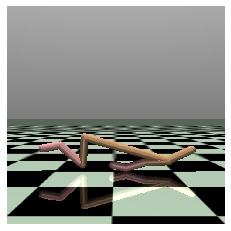

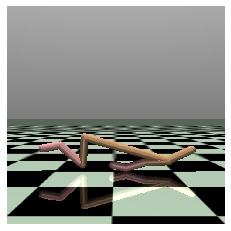

In [27]:
env.reset()
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    # plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    # plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

for i in range(10):
    env.step(1)
    show_state(env, i)
    time.sleep(1e-3)

# plt.imshow(env.render(mode='rgb_array'))

## Watch video (the best way)

In [28]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [29]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [30]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

### Use utils:

In [31]:
# def load_pytorch_policy(fpath, itr, deterministic=False):
#     """ Load a pytorch policy saved with Spinning Up Logger."""
  
#     fname = osp.join(fpath, 'pyt_save', 'model'+itr+'.pt')
#     print('\n\nLoading from %s.\n\n'%fname)

#     model = torch.load(fname)

#     # make function for producing an action given a single state
#     def get_action(x):
#         with torch.no_grad():
#             x = torch.as_tensor(x, dtype=torch.float32)
#             action = model.act(x)
#         return action

#     return get_action
get_action = load_pytorch_policy(fpath = output_path, itr = '')



Loading from /content/drive/MyDrive/Colab Notebooks/mipt_3_sem/RL/Spinningup_recreate/output/pyt_save/model.pt.




### Same without utils

In [32]:

# model_path = output_path + '/pyt_save/model.pt'
# model = torch.load(model_path)
# # make function for producing an action given a single state
# def get_action(x):
#     with torch.no_grad():
#         x = torch.as_tensor(x, dtype=torch.float32)
#         action = model.act(x)
#     return action

In [33]:
#env = wrap_env(gym.make("MountainCar-v0"))
env = wrap_env(env_fn())

s = env.reset()

for i in range(100):
    chosen_action = get_action(s)
    s, r, done, _ = env.step(chosen_action)
    if done: 
      break;
    # env.step(0.1)
    # show_state(env, i)

# while True:
  
#     env.render()
    
#     #your agent goes here
#     action = env.action_space.sample() 
         
#     observation, reward, done, info = env.step(action) 
   
        
#     if done: 
#       break;
            
env.close()
show_video()

# Plot loss

In [34]:
# make_plots([output_path])


In [35]:
final_progress_df = pd.read_csv(output_path+'/progress.txt', sep='\t')
# final_progress_df.head()

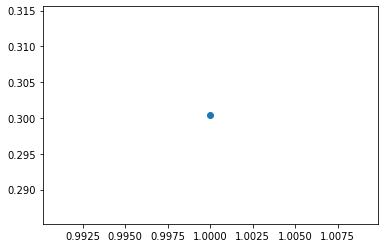

In [36]:
# import matplotlib.pyplot as plt
plt.scatter(final_progress_df['Epoch'], final_progress_df['LossQ'])
plt.show() # Depending on whether you use IPython or interactive mode, etc.

In [37]:

# final_progress_df.plot(x='Epoch', y='LossQ', style='o')